In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bid-ask-spread/input_training_imet9ZU.csv
/kaggle/input/bid-ask-spread/output_training_yCN1f2d.csv
/kaggle/input/bid-ask-spread/input_test_4AhEauI.csv


In [2]:
input_train=pd.read_csv("/kaggle/input/bid-ask-spread/input_training_imet9ZU.csv")
input_test=pd.read_csv("/kaggle/input/bid-ask-spread/input_test_4AhEauI.csv")
output_train=pd.read_csv("/kaggle/input/bid-ask-spread/output_training_yCN1f2d.csv")

In [3]:
output_train.drop("ID",axis=1,inplace=True)
output_train.head()


,spread
0,2.552161
1,3.575163
2,5.351175
3,5.285281
4,9.712062


In [4]:
input_train["contract_time"]=input_train["dt_expiry"]-input_train["dt_close"]
input_train["avg_price"]=(input_train["high"] + input_train["low"] + input_train["open"] + input_train["close"])/4
input_train["volatility"]=2*(input_train["high"] - input_train["low"])/(input_train["high"] + input_train["low"])
input_train["volatility_2"]=2*(input_train["open"] - input_train["close"])/(input_train["open"] + input_train["close"])
input_train.head()
#input_test[input_test["normal_trading_day"]==0].count()

,ID,dt_close,product_id,liquidity_rank,normal_trading_day,dt_expiry,open,high,low,close,open_interest,volume,tick_size,fixed,contract_time,avg_price,volatility,volatility_2
0,0,8862,401920,0,1,8952,2710.0,2721.0,2624.0,2635.0,2814,402,11,0,90,2672.50,0.036296,0.028064
1,1,8862,401920,1,1,8995,2610.0,2638.0,2547.0,2560.0,905,107,11,0,133,2588.75,0.035101,0.019342
2,2,8862,401920,2,1,9039,2530.0,2550.0,2468.0,2478.0,719,41,11,0,177,2506.50,0.032682,0.020767
3,3,8862,401920,3,1,9104,2497.0,2508.0,2437.0,2443.0,466,25,11,0,242,2471.25,0.028716,0.021862
4,4,8862,401920,4,1,9213,2474.0,2505.0,2443.0,2452.0,286,11,11,0,351,2468.50,0.025061,0.008932


In [6]:
array1=input_train["product_id"].unique()
array2=input_test["product_id"].unique()

array=[]

for num in array1:
    if num not in array2:
        array.append(num)
        
print(array)

[np.int64(42886656), np.int64(63489024)]


In [5]:
#dropped_columns=["dt_expiry","fixed","ID","liquidity_rank","high","low","open","close","tick_size","normal_trading_day"]
dropped_columns=["dt_expiry","fixed","ID"]
input_new=input_train.drop(dropped_columns,axis=1)
input_new.shape
#input_data=input_data[input_data["normal_trading_day"]==1]
#input_data.shape


(629611, 15)

In [6]:
data=input_new.copy()
data["spread"]=output_train.copy()

data_new=data[(data["product_id"]==42886656) | (data["product_id"]==63489024)]
data_new.head()

Y=data_new["spread"]
X=data_new.drop("spread",axis=1)

Y = pd.DataFrame(Y, columns=['spread'])



<Axes: >

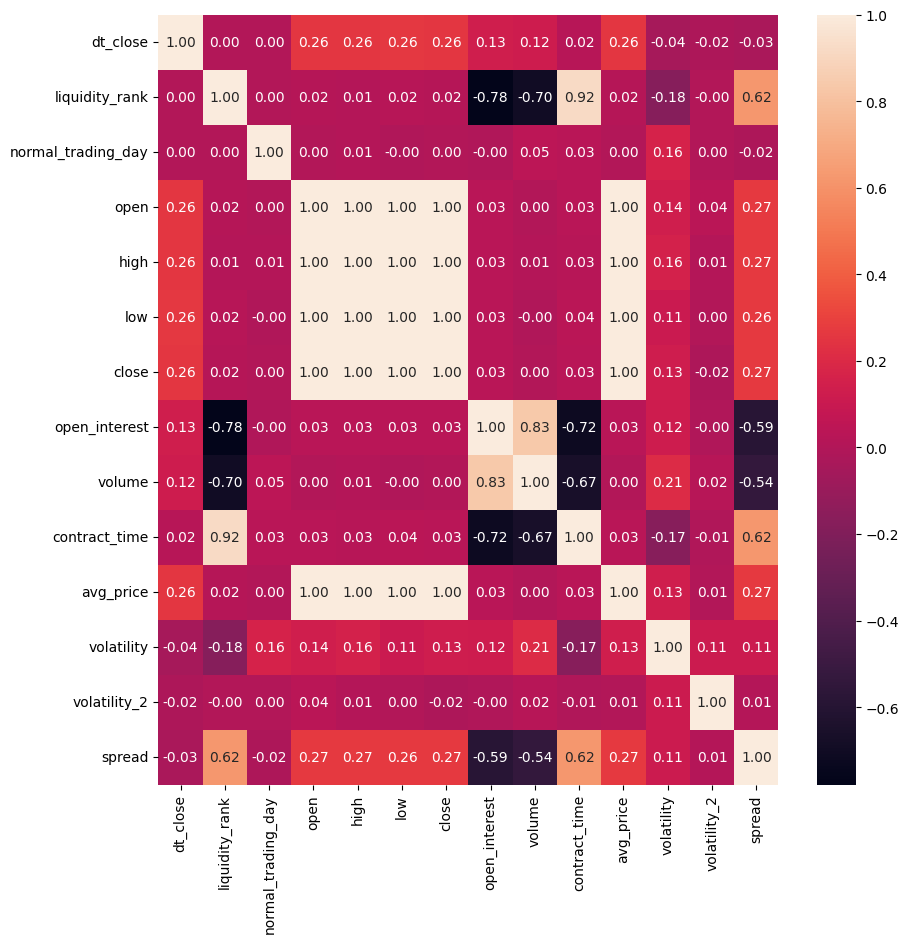

In [39]:
corr_mat=data[data["product_id"]==63489024].drop("product_id",axis=1).corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr_mat,annot=True,fmt=".2f")

In [7]:
dropped_columns=["high","low","liquidity_rank","open_interest","normal_trading_day","volatility_2","avg_price"]
X.drop(dropped_columns,axis=1,inplace=True)
input_new.drop(dropped_columns,axis=1,inplace=True)
#print(X.shape,input_new.shape)
#input_new.head()

In [8]:
input_new.head()

,dt_close,product_id,open,close,volume,tick_size,contract_time,volatility
0,8862,401920,2710.0,2635.0,402,11,90,0.036296
1,8862,401920,2610.0,2560.0,107,11,133,0.035101
2,8862,401920,2530.0,2478.0,41,11,177,0.032682
3,8862,401920,2497.0,2443.0,25,11,242,0.028716
4,8862,401920,2474.0,2452.0,11,11,351,0.025061


In [9]:
from sklearn.model_selection import train_test_split

X_train,X_val,Y_train,Y_val=train_test_split(X,Y,test_size=0.4,random_state=42)

new_training_data_X=pd.concat([X_train,input_new[(input_new["product_id"]!=42886656) & (input_new["product_id"]!=63489024)]],ignore_index=True)
new_training_data_Y=pd.concat([Y_train,output_train[(data["product_id"]!=42886656) & (data["product_id"]!=63489024)]],ignore_index=True)

In [56]:
#np.sum(X_train["product_id"]==63489024)
#np.sum(new_training_data["product_id"]==63489024)
#new_training_data_Y.head()
#new_training_data_Y[(new_training_data_X["dt_close"]==8862) & (new_training_data_X["product_id"]==401920)].head()

,spread
17325,2.552161
17326,3.575163
17327,5.351175
17328,5.285281
17329,9.712062


In [12]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

#depth_and_learning_rates=[(4,0.05),(4,0.1),(4,0.5),(6,0.05),(6,0.1),(6,0.5),(8,0.05),(8,0.1),(8,0.5)]

depth_and_learning_rates=[(8,0.1),(8,0.5),(10,0.1)]
rmse=[]

for item in depth_and_learning_rates:
    
    model = CatBoostRegressor(depth=item[0],learning_rate=item[1],early_stopping_rounds=20,loss_function="RMSE",verbose=False)
    model.fit(new_training_data_X, new_training_data_Y,cat_features=["product_id"])
    
    y_train_pred = model.predict(new_training_data_X)
    rmse_train = mean_squared_error(new_training_data_Y,y_train_pred)

    y_val_pred=model.predict(X_val)
    rmse_val= mean_squared_error(Y_val,y_val_pred)

    rmse.append((rmse_train,rmse_val))

print(rmse)

[(0.5838283353392405, 0.2670362959646208), (0.42687637540615075, 0.2668567471737011), (0.5000126420858156, 0.25078414096046114)]


In [14]:
input_test["contract_time"]=input_test["dt_expiry"]-input_test["dt_close"]
#input_test["avg_price"]=(input_test["high"] + input_test["low"] + input_test["open"] + input_test["close"])/4
input_test["volatility"]=2*(input_test["high"] - input_test["low"])/(input_test["high"] + input_test["low"])
#input_test["volatility_2"]=2*(input_test["open"] - input_test["close"])/(input_test["open"] + input_test["close"])
#input_test.head()
dropped_columns_2=["dt_expiry","fixed","ID","high","low","liquidity_rank","normal_trading_day","open_interest"]
X_test=input_test.drop(dropped_columns_2,axis=1)
X_test.head()

#model = CatBoostRegressor(depth=8,learning_rate=0.3,early_stopping_rounds=50,loss_function="RMSE",verbose=False)
#model.fit(new_training_data_X, new_training_data_Y,cat_features=["product_id"])

#y_train_pred = model.predict(new_training_data_X)
#rmse_train = mean_squared_error(new_training_data_Y,y_train_pred)

#y_val_pred=model.predict(X_val)
#rmse_val= mean_squared_error(Y_val,y_val_pred)

test_pred=model.predict(X_test)


In [98]:
test_pred[:10]

array([1.70165937, 2.46001407, 2.67562847, 3.22681154, 4.42941004,
       4.57047324, 3.74701918, 6.41641537, 1.29587247, 1.49022718])

In [15]:
df=pd.DataFrame({"ID":input_test["ID"],"spread":test_pred})
df.to_csv("predictions2.csv",index=False)

In [66]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.get_feature_importance()
}).sort_values('importance', ascending=False)

print(feature_importance)

         feature  importance
1     product_id   25.776797
5      tick_size   18.409808
0       dt_close   11.773388
6  contract_time   11.755072
2           open   10.581509
3  open_interest    9.791037
4         volume    9.592720
7     volatility    2.319668


In [11]:
#corr = input_data["product_id"==401920]["liquidity_rank"==0].corr(numeric_only=True)

#plt.figure(figsize=(8,6))
#sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
#plt.show()

In [12]:
#product_ids=input_data["product_id"].unique()

#ticksize=defaultdict(list)

#for pid in product_ids:
#    ticksize[pid].append(input_data[input_data["product_id"]==pid]["tick_size"].unique())

#input_data[input_data["product_id"]==1470464]

In [13]:
#from sklearn.preprocessing import MinMaxScaler

#cols=["open","close","high","low"]

#for col in cols:
    
 #   input_data[col+"_scaled"]=input_data.groupby("product_id")["col"].transform(lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1,1)).ravel())

#input_data.head()